In [2]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {'width':1400,'scroll': True})

{'width': 1400, 'height': 768, 'scroll': True}

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from scipy.signal import argrelextrema
import math
import numpy as np
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.legend_handler import HandlerBase
import matplotlib.pyplot as plt
import sys
import os,glob
import yaml
from scipy.special import gamma
from scipy.optimize import fsolve
from scipy.interpolate import interp1d  
import pandas as pd
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from decimal import Decimal
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size']=13
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='stix'
plt.rcParams['figure.figsize']= (6.5,4)
plt.rcParams['figure.dpi']=150
plt.rcParams['axes.facecolor'] = 'white'

class VDS0():  

############################# INITIALIZATION #############################
    
    def __init__(self, h = 0.6727, Omega_m = 0.26495, Omega_b = 0.05, Omega_rad = 10e-5, p_crit = 4.755e-6,
                 rho_crit = 4.755e-6, T0 = 2.7255, kb = 8.617333262145e-5, m_p = 0.93827231, nu = 1.12,
                 Y_p = 0.75, n_e = 0.18820, x_e = 1.16371, sigmaT = 6.65246e-29, c = 3e5, Mpc2cm = 3.086e24, 
                 masses = np.array([1e-4,1e-3,1e-2,1e-1,1.,10.]), 
                 sigma_array = np.logspace(-10,-40,200)):
        
        self.h = h
        self.H0 = 100*h
        self.Omega_m = Omega_m
        self.Omega_b = Omega_b
        self.Omega_rad = Omega_rad
        self.Y_p = Y_p
        self.m_p = m_p
        self.nu = nu
        self.n_e = n_e
        self.x_e = x_e
        self.sigmaT = sigmaT
        self.rho_crit = 1.256*10**11*Omega_m
        self.rho_b = Omega_b*p_crit
        self.T_0 = kb*T0*1e-9
        self.Mpc2m = Mpc2cm*1e-2
        self.Rx_conerverionFactor = c*Mpc2cm
        
        self.masses = masses
        self.sigma_array = sigma_array
            
############################# SEMI-ANALYTIC FUNCTIONS #############################
    
    def N_0(self,n):
        return pow(2,(5.+n)/2.)*gamma(3.+n/2.)/(3.*np.sqrt(np.pi))

    def mhm2khm(self,Mhm):
        return np.pi/self.h*(((4.*np.pi*self.rho_crit)/(3*Mhm))**(1./3.))
        
    def Rx(self,z,sigma_0, m_x, n):
        return pow(z,2)*self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p))*(pow(((self.T_0*(1+z))/(m_x))+((self.T_0*(1+z))/self.m_p),((1.+n)/2.)))

    def Rx_noZ(self,sigma_0, m_x, n):
        return self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p))*(pow((self.T_0/m_x)+(self.T_0/self.m_p),((1.+n)/2.)))
    
    def Rx_kin(self,z,sigma_0,m_x,n):
        return (pow(z,2) * ((self.T_0*z**2)/(self.z_th(sigma_0,m_x,n)*m_x) + (self.T_0*z)/self.m_p)**((n+1.)/2.))*(self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p)))

    def Rx_th(self,z,sigma_0, m_x, n):
        return pow(z,2)*self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p))*(pow((self.T_0*z)/(m_x)+((self.T_0*z)/self.m_p),((1.+n)/2.)))
    
    def Rgamma(self,z):
        return pow(z,2)*self.n_e*self.x_e*self.sigmaT*self.Mpc2m
    
    def aH(self,z,sigma_0,m_x,n):
        return z*(self.H0*np.sqrt(self.Omega_rad))

    def z_th(self,sigma_0,m_x,n):
        return ((self.H0*np.sqrt(self.Omega_rad)*(m_x+self.m_p))/(self.Rx_noZ(sigma_0,m_x,n)*m_x))**(2./(n+3.))

    def z_kin(self,sigma_0,m_x,n):
        return fsolve(lambda z: z * ((self.T_0*z**2)/(self.z_th(sigma_0,m_x,n)*m_x) + (self.T_0*z)/self.m_p)**((n+1.)/2.) - (self.H0*np.sqrt(self.Omega_rad)/(self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor))*(m_x+self.m_p)/sigma_0,self.z_th(sigma_0,m_x,n)/2.)    
    
    def z_gamma(self,sigma_0,m_x,n):
        return fsolve(lambda z: ((self.T_0*z**2)/(self.z_th(sigma_0,m_x,n)*m_x) + (self.T_0*self.z_th(sigma_0,m_x,n))/self.m_p)**((n+1.)/2.) - (self.n_e*self.x_e*self.sigmaT*self.Mpc2m/(self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor))*(m_x+self.m_p)/sigma_0,self.z_th(sigma_0,m_x,n)/2.)    

    def sigma2k(self,sigma_0,m_x,n):
        return 2*(self.H0*np.sqrt(self.Omega_rad)*self.z_kin(sigma_0,m_x,n))*3.33e-6
    
    def sigma2k2(self,sigma_0,m_x,n):
        return 2*(self.H0*np.sqrt(self.Omega_rad)*self.z_gamma(sigma_0,m_x,n))*3.33e-6

    def sig(self,klimit,n):
        sigma = []
        for i in range(len(self.masses)):
            sigma.append(self.sigma_array[np.argmin(np.abs(self.sigma2k(self.sigma_array,self.masses[i],n)-self.h*klimit))])
        return np.array(sigma)

    def sig2(self,klimit,n):
        sigma = []
        for i in range(len(self.masses)):
            sigma.append(self.sigma_array[np.argmin(np.abs(self.sigma2k2(self.sigma_array,self.masses[i],n)-self.h*klimit))])
        return np.array(sigma)
    
    def sigma_vs_mx(self,klimit,n):
        return hv.Curve((masses, self.sig(klimit,n)))
    
############################# INI GENERATION #############################

    def make_inis(self,ini_base_file='class/inis/dmeff_base.ini',base_inis_path='class/inis/',class_runner_path = 'class/',npow=0,
                  masses=np.array([1e-4,1e-3,1e-2,1e-1,1.,10.]),sigmas=np.logspace(-20,-30,100),output_path='pk_output',
                  sh_file='class/run_classes.sh'):
    
        fin =  open(ini_base_file, 'r')
        base_content = fin.read()
        fin.close()
        fout_sh = open(class_runner_path+'run_classes.sh', 'w')

        for m in masses:
            for sigma in sigmas:
                filename = 'n{}_m{}_s{}.ini'.format(npow,m,sigma)
                fout_sh.write('./class ' + 'inis/{}\n'.format(filename))
                fout = open(base_inis_path + filename, 'w')
                fout.write(base_content)
                fout.write('\n')
                npow_line = 'npow_dmeff = {}\n'.format(npow)
                fout.write(npow_line)
                m_line = 'm_dmeff = {}\n'.format(m)
                fout.write(m_line)
                sigma_line = 'sigma_dmeff = {}\n'.format(sigma)
                fout.write(sigma_line)
                if npow<0:
                    vel_line = 'Vrel_dmeff_rate = 30\n' #sets to DBK case.
                    fout.write(vel_line)
                root_line = 'root = {}/n{}_m{}_s{}_\n'.format(output_path,npow,m,sigma)
                fout.write(root_line)

        fout_sh.close()

############################# TK PLOTTING FUNCTIONS #############################
        
    def single_tk(self,npow=0,m=0.0001,plotPeaks=False,pltType='none',
                  index=0,sigmas=np.logspace(-20,-30,100),lw=2.5,label='',
                  c='k',ls='-',alpha=1):

        data0 = np.loadtxt('class/pk_output/lcdm_z1_pk.dat')
        ks = data0[:,0]
        pk0 = data0[:,1]

        for i,sigma in enumerate(sigmas):
            # Index of interest
            if i!=index:
                continue
            print("Cross-section (sigma0) =",sigma)
            
            # pk data from class for given mass, sigma, power
            filename = 'class/pk_output/n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)
            np.loadtxt(filename)
            data = np.loadtxt(filename)
            pk = data[:,1]
            
            ax.plot(ks,(pk)/pk0,linewidth=lw,linestyle=ls,color=c,label=label,alpha=alpha)

        return (pk)/pk0,ks,sigma
    
    def all_sigmas(self,npow=0,m=0.0001,sigmas=np.logspace(-20,-30,100),
               z='z1',colorbar=False,pk_root='class/pk_output/',
               filename=None,label='',lw=0.3,lowlim=0,uplim=100,c='r'):
        
        cm = LinearSegmentedColormap.from_list("mycmap", ['#D81B60','tan','#63acbe'])
        cm2 = LinearSegmentedColormap.from_list("mycmap", ['#63acbe','tan','#D81B60'])
        
        data0 = np.loadtxt('class/pk_output/lcdm_z1_pk.dat')
        ks = data0[:,0]
        pk0 = data0[:,1]

        for i,sigma in enumerate(sigmas):
            if i>=uplim or i<lowlim or i==len(sigmas)-1 or i%15!=0:
                continue
                
            # colors/labels for peak plot
            lbl = "$\sigma_0=$"+str('{:.1e}'.format(float(sigma)))+r"$\textrm{ cm}^2$"
            c=cm(int(i*4.))

            try:                                    
                # pk data from class for given mass, sigma, power
                filename = 'class/pk_output/n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)            
                data = np.loadtxt(filename)
                pk = data[:,1]
                ax.semilogx(ks,pk/pk0,linewidth=lw,linestyle='-',color=c,alpha=1.) 
                sc = plt.scatter(ks,(pk)/pk0, c=np.logspace(-20,-30,246), cmap=cm2,s=0.001,alpha=0.7)
            except: continue

        if colorbar:
            tick_locs = [1e-30,1e-20]
            tick_labels = ["$\sigma_0 = 10^{-30}$ cm$^2$","$\sigma_0 = 10^{-20}$ cm$^2$"]
            cb = plt.colorbar(sc, orientation="vertical")
            cb.locator = matplotlib.ticker.FixedLocator(tick_locs)
            cb.formatter = matplotlib.ticker.FixedFormatter(tick_labels)
            cb.update_ticks()
            cb.ax.tick_params(labelsize=33,length=15,width=3,color='w')
            cb.ax.locator_params(nbins=2)
           
    def all_masses(self,npow=0,masses=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1],
                   sigma=1e-20,z='z1',colorbar=False,pk_root='class/pk_output/',
                   filename=None,label='',lw=0.3):
        
        cm = LinearSegmentedColormap.from_list("mycmap", ['#63acbe','tan','#D81B60'])
    
        data0 = np.loadtxt('class/pk_output/lcdm_z1_pk.dat')
        ks = data0[:,0]
        pk0 = data0[:,1]

        for i,m in enumerate(masses):
            lbl = "$\mass=$"+str('{:.1e}'.format(float(m)))+r"$\textrm{ GeV}$"
            c=cm(int(i*35.))

            # pk data from class for given mass, sigma, power
            filename = 'class/pk_output/n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)            
            data = np.loadtxt(filename)
            pk = data[:,1]

            ax.semilogx(ks,pk/pk0,linewidth=lw,linestyle='-',color=c,label=lbl,alpha=1.) 
            sc = plt.scatter(ks,(pk)/pk0, c=np.logspace(-20,-30,246), cmap=cm,s=0.001,alpha=0.7)
                
        if colorbar:
            tick_locs = [1e-30,1e-20]
            tick_labels = ["$m = 10^{-5}$ GeV","$m = 10$ GeV"]
            cb = plt.colorbar(sc, orientation="vertical")
            cb.locator = matplotlib.ticker.FixedLocator(tick_locs)
            cb.formatter = matplotlib.ticker.FixedFormatter(tick_labels)
            cb.update_ticks()
            cb.ax.tick_params(labelsize=33,length=15,width=3,color='w')
            cb.ax.locator_params(nbins=2)
            
    def transfer(self,k,mwdm):
        lambda_fs = (0.049*(mwdm**(-1.11))*((self.Omega_m/0.25)**(0.11))*((self.h/0.7)**1.22))
        alpha = lambda_fs
        transfer = (1+(alpha*k)**(2*self.nu))**(-5./self.nu)
        return transfer

vds0 = VDS0()
masses_test = [1e-4,1e-3,1e-2,1e-1,1.,10.]
smallSigs = np.logspace(-20,-30,100)
smallSigs2 = np.logspace(-17,-30,100)
largeSigs = np.logspace(-10,-30,100)

# Limits on DM-Proton Interactions <br><br>
<font color=maroon>Karime</font>

## Objective

Put limits on dark matter-proton scattering cross-sections

## Approaches

1. <font color=teal>Analytic</font> (Gluscevic & Boddy)

2. <font color=crimson>Conservative</font> (Fitting transfer functions)

# Formalism

Compton scattering rate = Hubble rate $\rightarrow$ **Photon decoupling** $\rightarrow$ "Let there be light"

Momentum transfer rate = Hubble rate $\rightarrow$ **Kinetic decoupling**

&nbsp; &nbsp; &nbsp; &nbsp;$R_{\chi}(z,\sigma_0,...)=aH(z) \rightarrow z_{crit}$

Size of horizon at $z_{crit}$ = $\lambda_{crit}$ = $2\pi/k_{crit}$

&nbsp; &nbsp; &nbsp; &nbsp;Where $k_{crit}$ is the scale at which power sufficiently suppressed

Assuming a sphere of radius $\frac{\lambda_{crit}}{2}$ permits the translation of $k_{crit}$ to $M_{crit}$

&nbsp; &nbsp; &nbsp; &nbsp;$\frac{4\pi}{3}\overline{\rho}\left(\frac{\lambda_{crit}}{2}\right)^3 =\frac{4\pi}{3}\overline{\rho}\left(\frac{\pi}{k_{crit}}\right)^3 = M_{crit}$

$\small M_{crit}(k(z(\sigma_0,...)))$

# <font color=teal>Analytic approach: </font> 
&nbsp; &nbsp; &nbsp; &nbsp;$\small M_{crit}(k(z(\sigma_0,...)))$

Start from Milky Way observations of the minimum halo mass of satellite galaxies: <br>
&nbsp; &nbsp; &nbsp; &nbsp;$M_{crit}=5.4\times 10^{8}M_{\odot}$

Given $M$, solve for $k$: <br>
&nbsp; &nbsp; &nbsp; &nbsp;$M_{crit}=\frac{4\pi}{3}\overline{\rho}\left(\frac{\pi}{k_{crit}}\right)^3$

In [4]:
Mhm=5.4e8
print('k =',np.pi/vds0.h*(((4.*np.pi*vds0.rho_crit)/(3*Mhm))**(1./3.)))

k = 29.735682838811993


Assert that the critical scale be a full oscillation of the cosmological horizon:<br>
&nbsp; &nbsp; &nbsp; &nbsp;$k_{crit}=2aH=2H_0\sqrt{\Omega_{rad}}z(\sigma_0,m_{\chi},n)$

In [5]:
# DM masses
masses = np.array([1e-4,1e-3,1e-2,1e-1,1.,10.])

# Velocity-dependencies
n=np.array([0,2,4,6])

# kcrit
klimit=29.7

# Interate through and pull out sigma0 corresponding to kcrit
for i in range(len(n)):
    sigma = []
    for j in range(len(masses)):
        sigma.append('%.2E' % Decimal(vds0.sigma_array[np.argmin(np.abs(vds0.sigma2k(vds0.sigma_array,masses[j],n[i])-vds0.h*klimit))]))
    print("For n =",n[i],":",np.array(sigma))

For n = 0 : ['4.06E-29' '8.12E-29' '1.15E-28' '2.30E-28' '6.52E-28' '3.70E-27']
For n = 2 : ['1.85E-27' '2.97E-26' '3.37E-25' '3.83E-24' '4.35E-23' '4.94E-22']
For n = 4 : ['2.97E-26' '3.83E-24' '4.94E-22' '4.50E-20' '2.90E-18' '6.59E-17']
For n = 6 : ['3.37E-25' '4.94E-22' '5.11E-19' '5.29E-16' '1.37E-13' '4.40E-12']


(0.0001, 10)

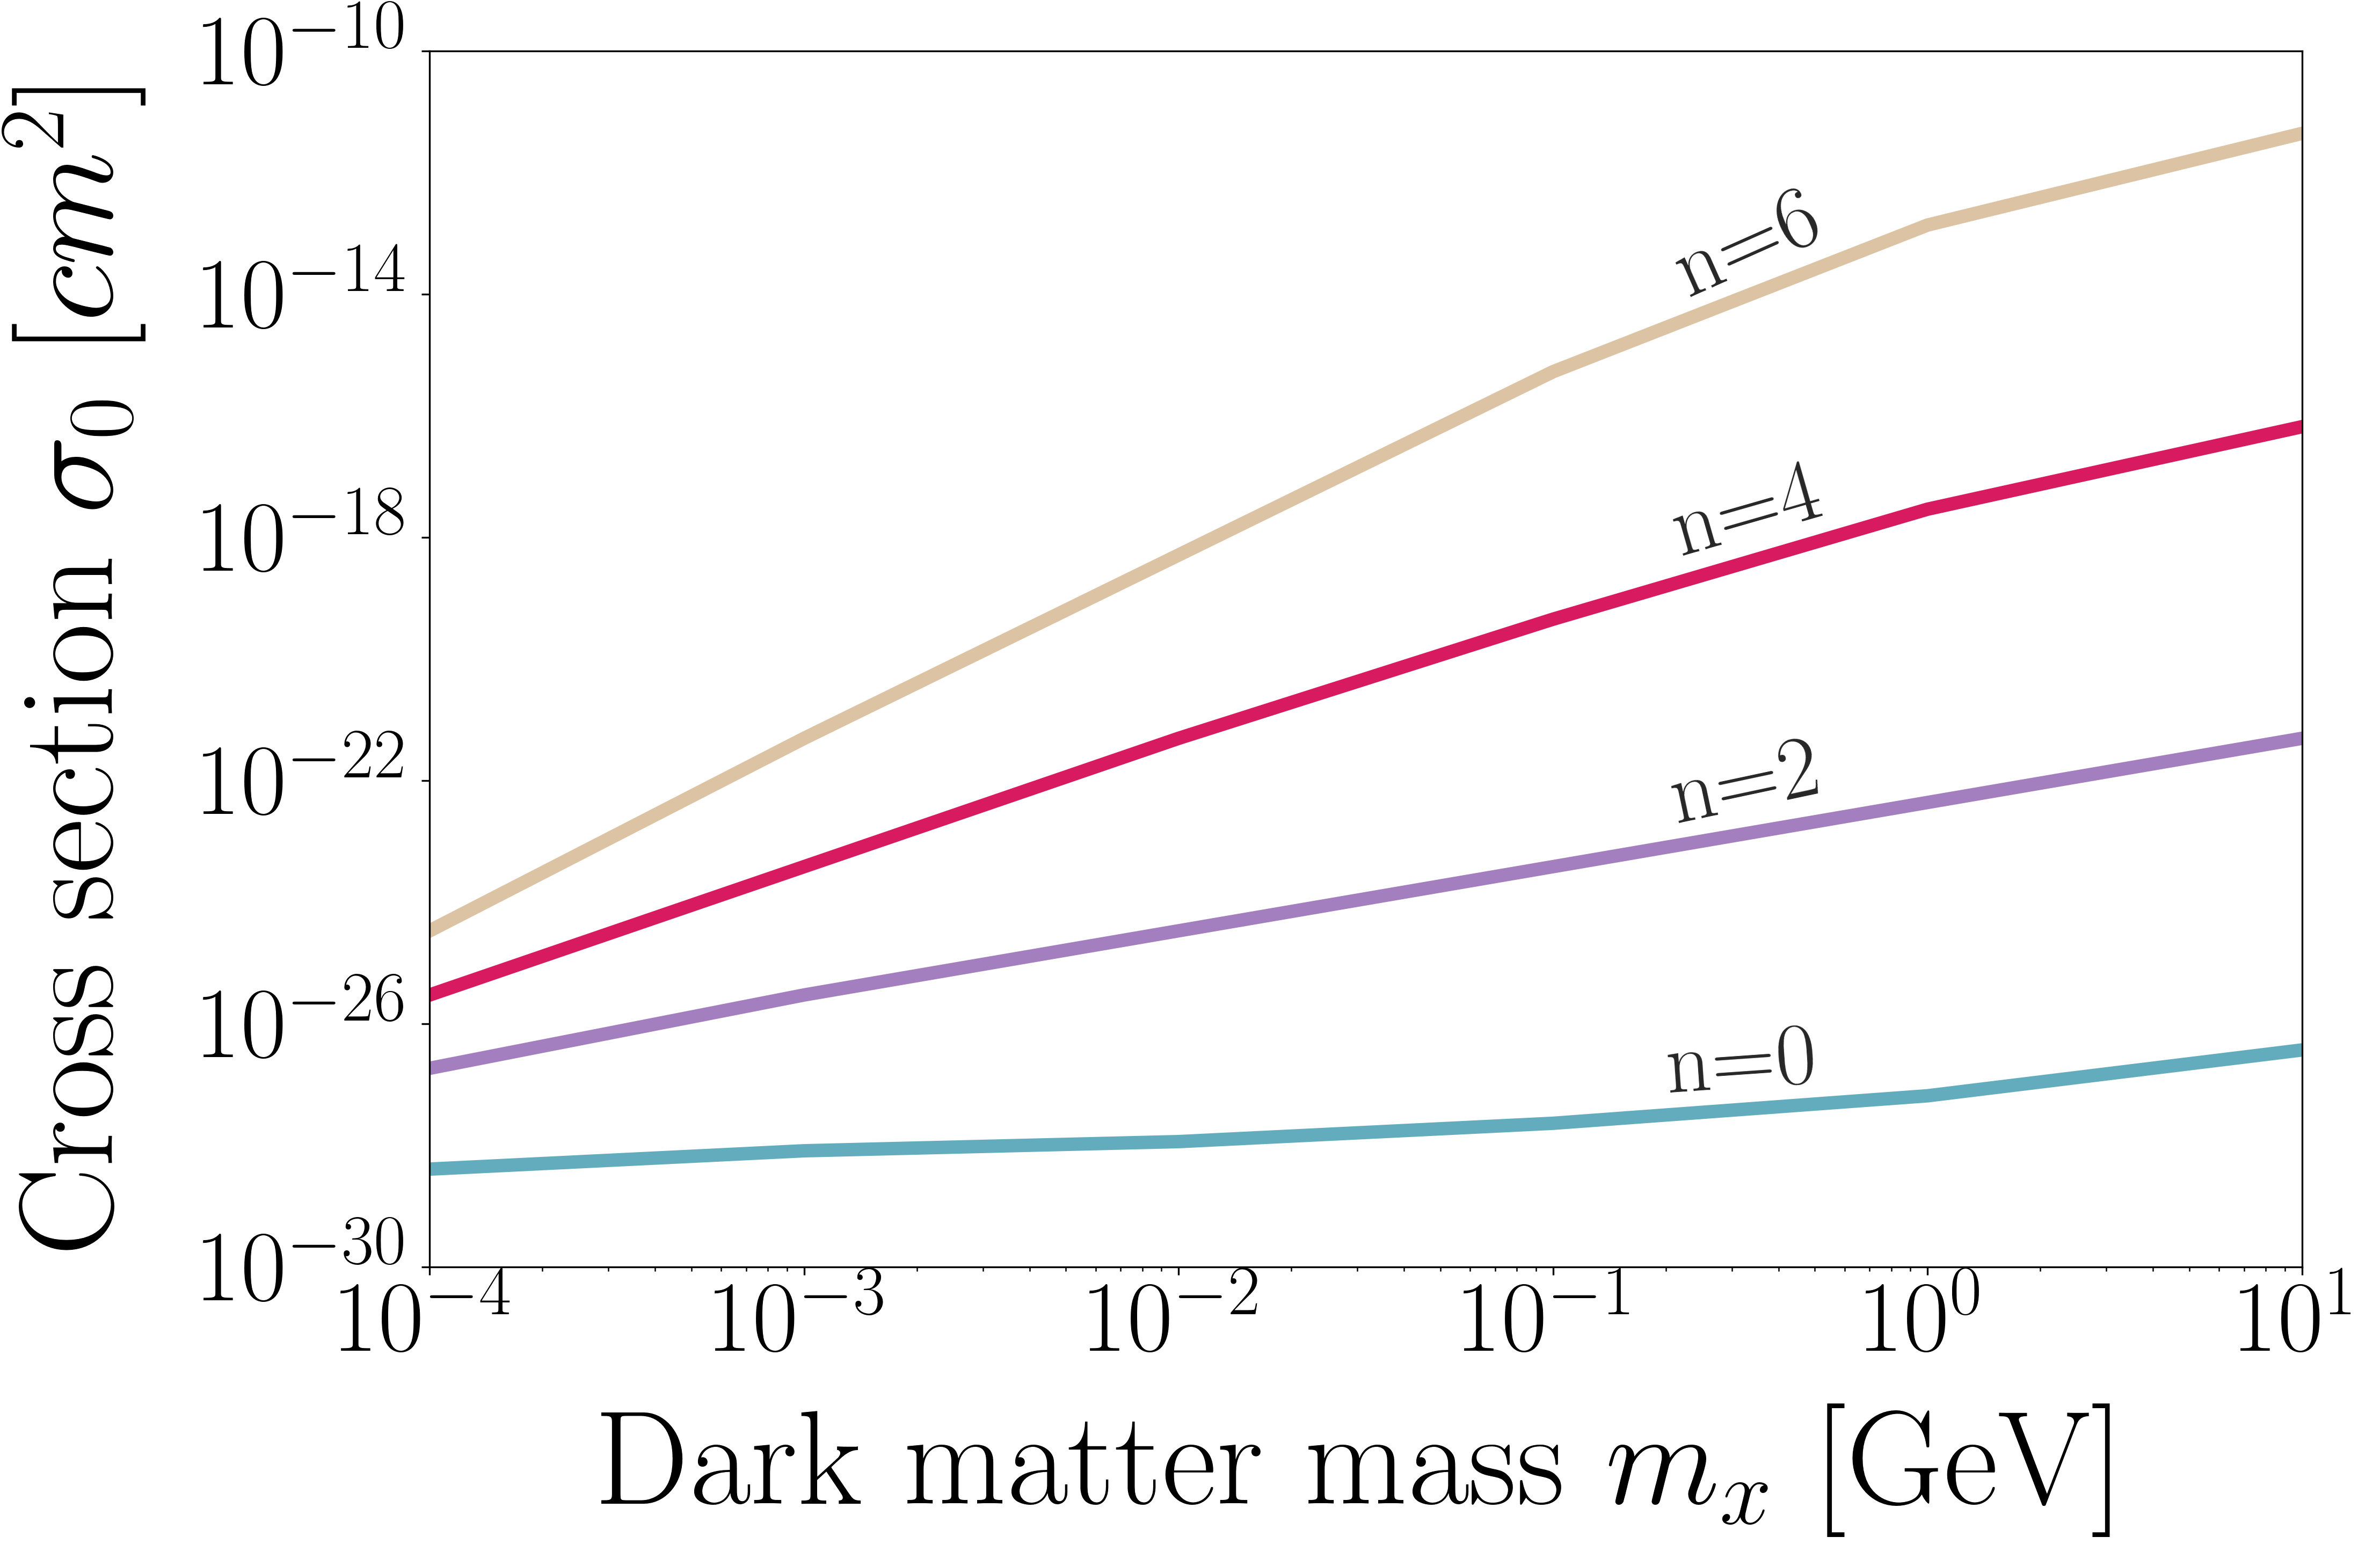

In [6]:
klim = vds0.mhm2khm(5.4*10**8)
kcmb = vds0.mhm2khm(1e14)
plt.figure(figsize=(15,10))
plt.loglog(vds0.masses, vds0.sig(klim,6.), label="n=6",linewidth=6,c='tan',alpha=0.8)
plt.loglog(vds0.masses, vds0.sig(klim,4.), label="n=4",linewidth=6,c='#D81B60')
plt.loglog(vds0.masses, vds0.sig(klim,2.), label="n=2",linewidth=6,c='indigo',alpha=0.5)
plt.loglog(vds0.masses, vds0.sig(klim,0.), label="n=0",linewidth=6,c='#63acbe')

plt.text(0.2,9e-15,"n=6",rotation=24,fontsize=40,alpha=0.85)
plt.text(0.2,5e-19,"n=4",rotation=16,fontsize=40,alpha=0.85)
plt.text(0.2,2e-23,"n=2",rotation=12,fontsize=40,alpha=0.85)
plt.text(0.2,7e-28,"n=0",rotation=4,fontsize=40,alpha=0.85)

plt.ylabel(r"Cross section $\sigma_0$ [$cm^2$]", fontsize=60,labelpad=20)
plt.xlabel(r"Dark matter mass $m_x$ [GeV]", fontsize=60,labelpad=20)
plt.tick_params(labelsize=45)
plt.ylim(1e-30,1e-10)
plt.xlim(1e-4,10)

# <font color=crimson>Conservative approach</font>

Start from Milky Way observations of the minimum halo mass of satellite galaxies: <br>
&nbsp; &nbsp; &nbsp; &nbsp;$M_{crit}=5.4\times 10^{8}M_{\odot}$

Given $M$, solve for $k$: <br>
&nbsp; &nbsp; &nbsp; &nbsp;$M_{crit}=\frac{4\pi}{3}\overline{\rho}\left(\frac{\pi}{k_{crit}}\right)^3$

In [7]:
Mhm=5.4e8
print('k =',np.pi/vds0.h*(((4.*np.pi*vds0.rho_crit)/(3*Mhm))**(1./3.)))

k = 29.735682838811993


Construct the WDM transfer function associated with a critical scale of $k_{crit}=29.7$ and fit IDM transfer functions accordingly

Cross-section (sigma0) = 3.5111917342151417e-26


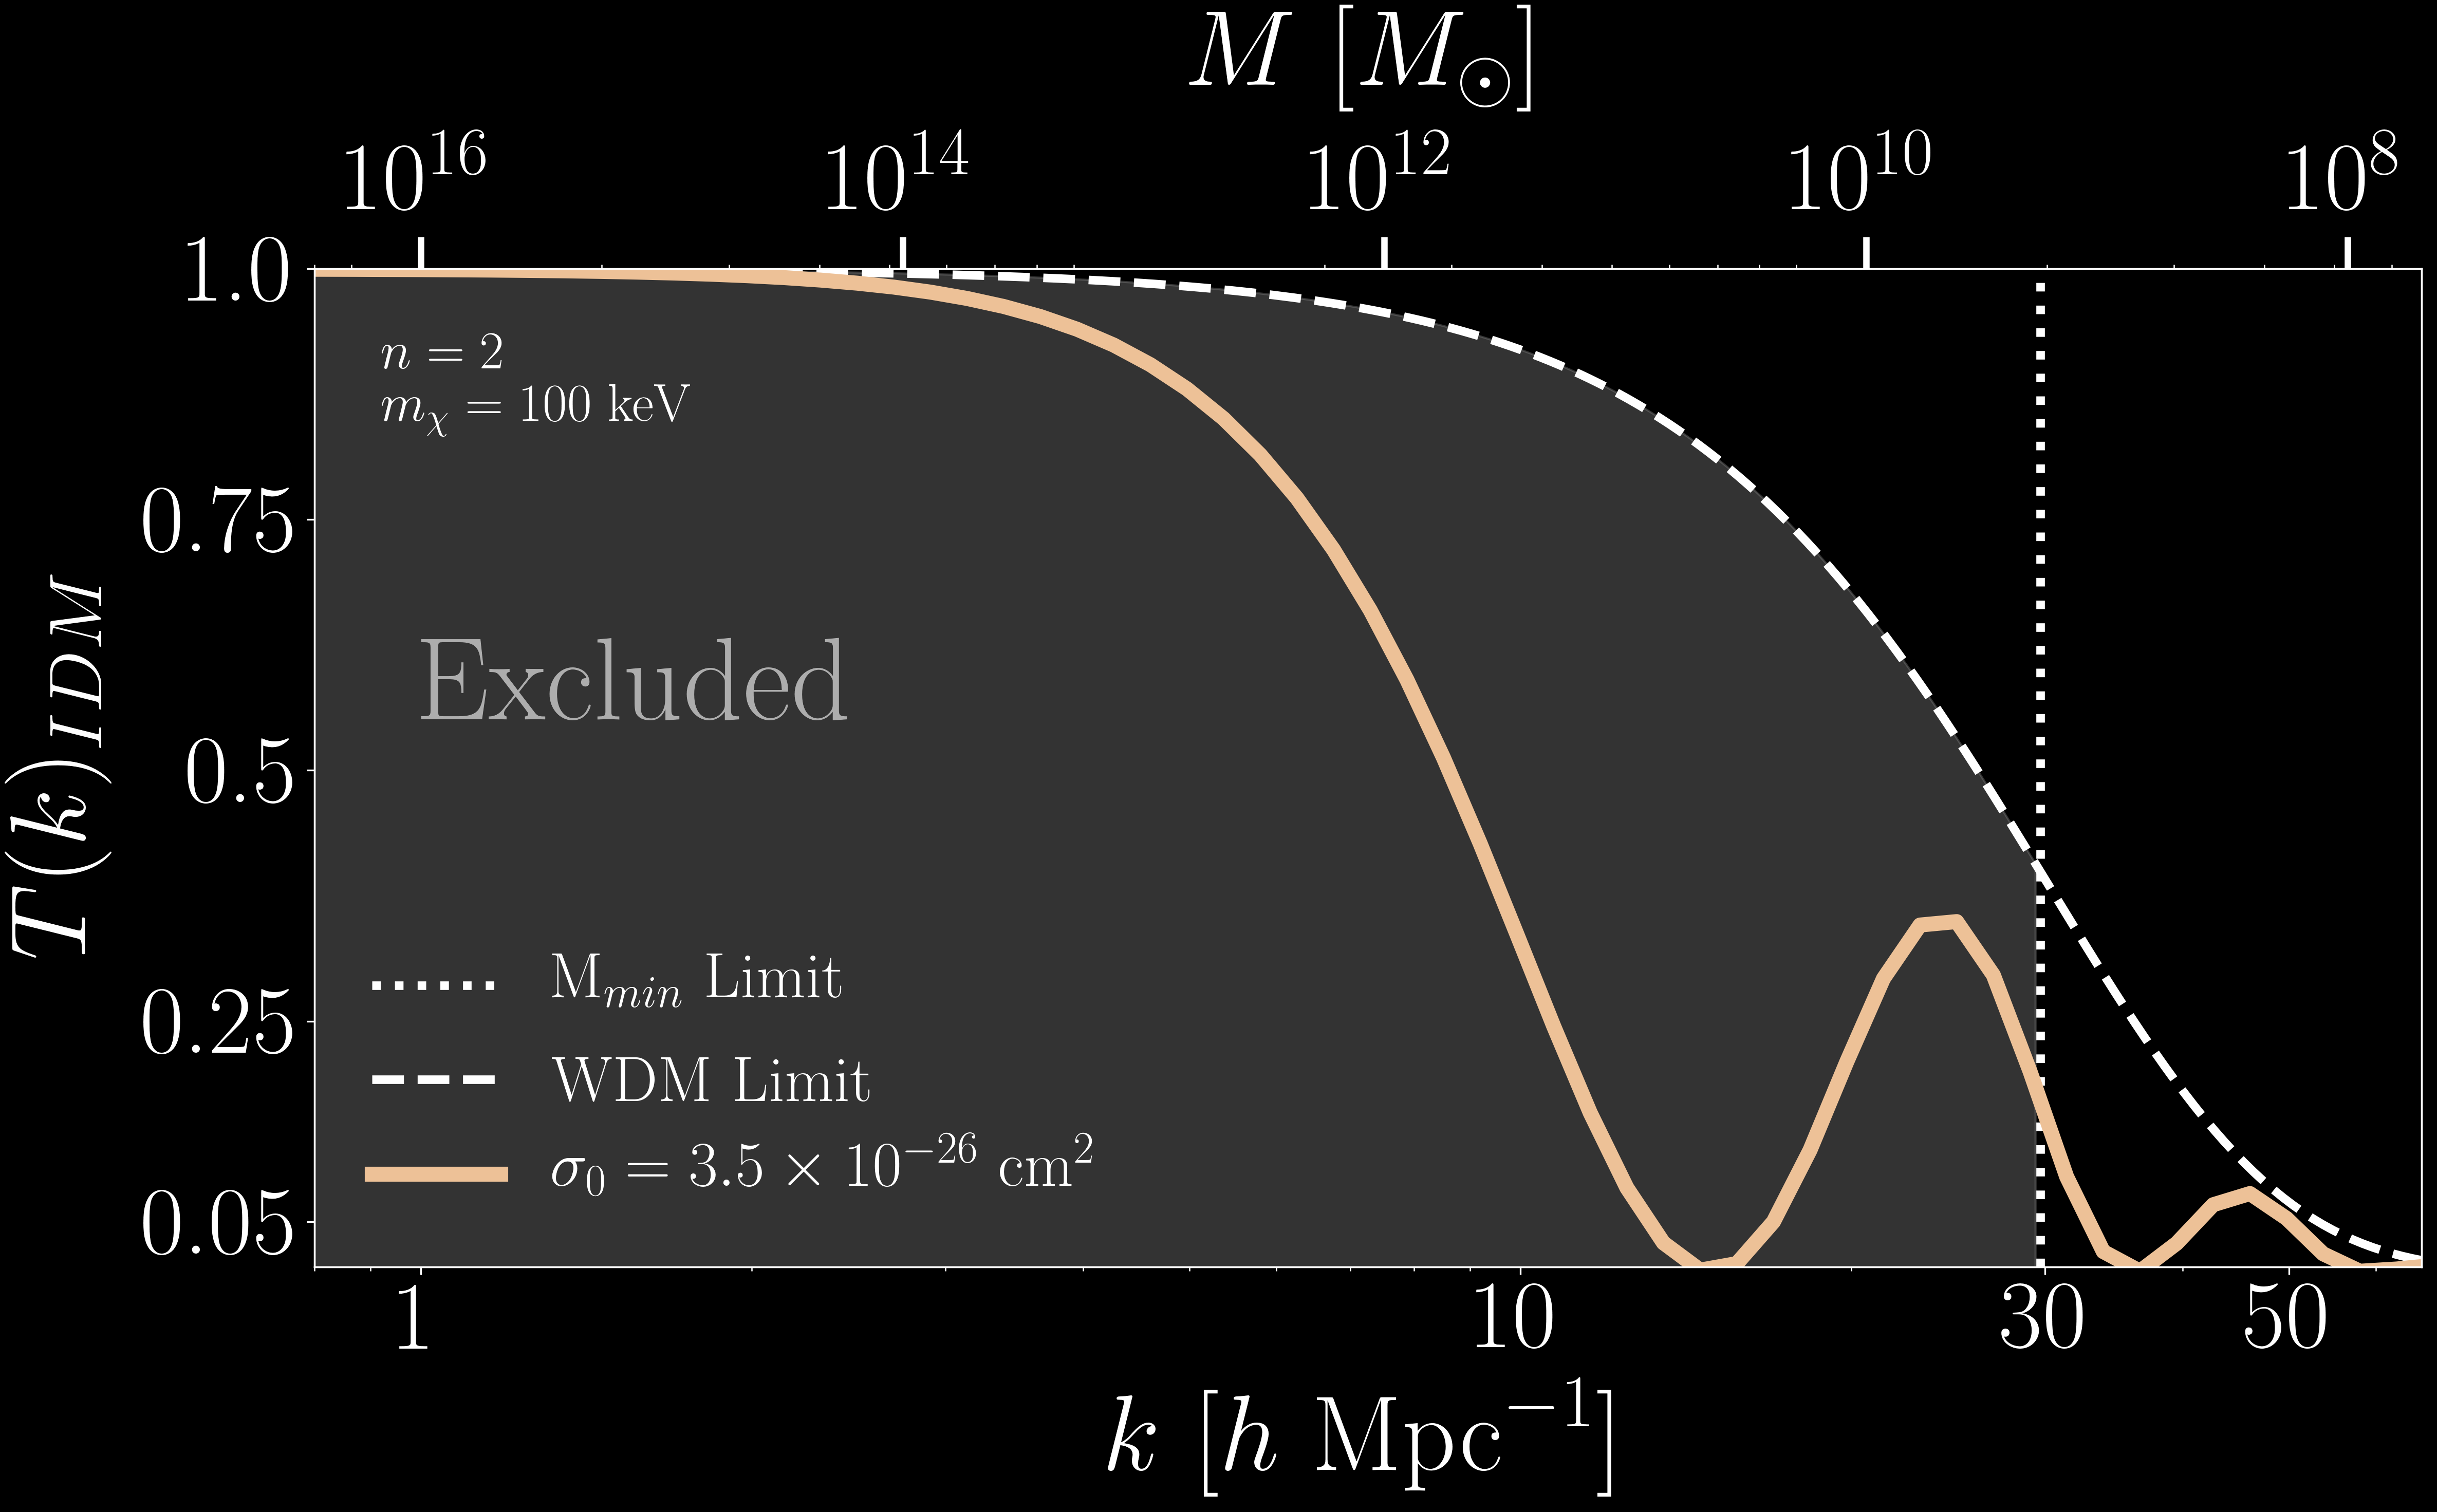

In [22]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(16,10))    
ax = fig.add_subplot(111)
ax2 = ax.twiny()
ax.text(1.,0.55,"Excluded",c='w',alpha=0.6,fontsize=55)

#********************************Mmin Limit***********************************#
ax.axvline(klimit,c='w',ls=':',lw=4,label=r'M$_{min}$ Limit')
#*****************************************************************************#

#**************************WDM Transfer Functions*****************************#
ks2 = np.logspace(-5,4,1000)
ax.semilogx(ks2,vds0.transfer(ks2,3.3)**2,linestyle='--',label='WDM Limit',c='w',lw=4)
ax.fill_between(np.logspace(-5,4,1000), -10, vds0.transfer(ks2,3.3)**2,where=np.logspace(-5,4,1000)<klimit,color='grey',alpha=0.4)
#*****************************************************************************#

#**************************IDM Transfer Functions*****************************#
# tk_idm,ks,sigma0 = vds0.single_tk(npow=2,m=0.0001,label=r'$\sigma_0=8.7\times 10^{-27}$ cm$^2$',c='#63acbe',sigmas=smallSigs,index=60,lw=4)
# tk_idm,ks,sigma0 = vds0.single_tk(npow=2,m=0.0001,label=r'$\sigma_0= 1.4\times 10^{-25}$ cm$^2$',c='khaki',sigmas=smallSigs,index=48,lw=4)
tk_idm,ks,sigma0 = vds0.single_tk(npow=2,m=0.0001,label=r'$\sigma_0= 3.5\times 10^{-26}$ cm$^2$',c='#edc197',sigmas=smallSigs,index=54,lw=7)
ax.text(0.92,0.84,"$n=2$\n$m_{\chi}=100$ keV",fontsize=25)
#*****************************************************************************#

ax.set_xscale('log')
ax.set_xlim(0.8,66)
ax.set_ylim(0.005,1.)
ax.set_xlabel(r'$k$ [$h\ \rm{Mpc}^{-1}$]',fontsize=50,labelpad=5)
ax.set_ylabel(r'$T(k)_{IDM}$',fontsize=50,labelpad=10)
ax.set_yticks([0.05,0.25,0.5,0.75,1.0])
ax.set_yticklabels([0.05,0.25,0.5,0.75,1.0],fontsize=45)
ax.set_xticks([1,10,30,50])
ax.set_xticklabels(["1","10","30","50"],fontsize=45)
ax.legend(fontsize=30,framealpha=0,loc='lower left')

ax2.set_xscale('log')
ax2.set_xlim(0.08,66)
ax2.set_xticks([vds0.mhm2khm(10**16),vds0.mhm2khm(10**14),vds0.mhm2khm(10**12),vds0.mhm2khm(10**10),vds0.mhm2khm(10**8)])
ax2.set_xticklabels([r'10$^{16}$',r'10$^{14}$',r'10$^{12}$',r'10$^{10}$',r'10$^{8}$'],fontsize=45)
ax2.set_xlabel(r'$M$ [$M_{\rm{\odot}}$]',fontsize=50,labelpad=20)
ax2.tick_params(length=15,width=3)
plt.tight_layout()
plt.savefig("conserv.png",transparent=True)

Cross-section (sigma0) = 9.770099572992246e-22
Cross-section (sigma0) = 1.4849682622544696e-23
Cross-section (sigma0) = 3.5111917342151417e-26


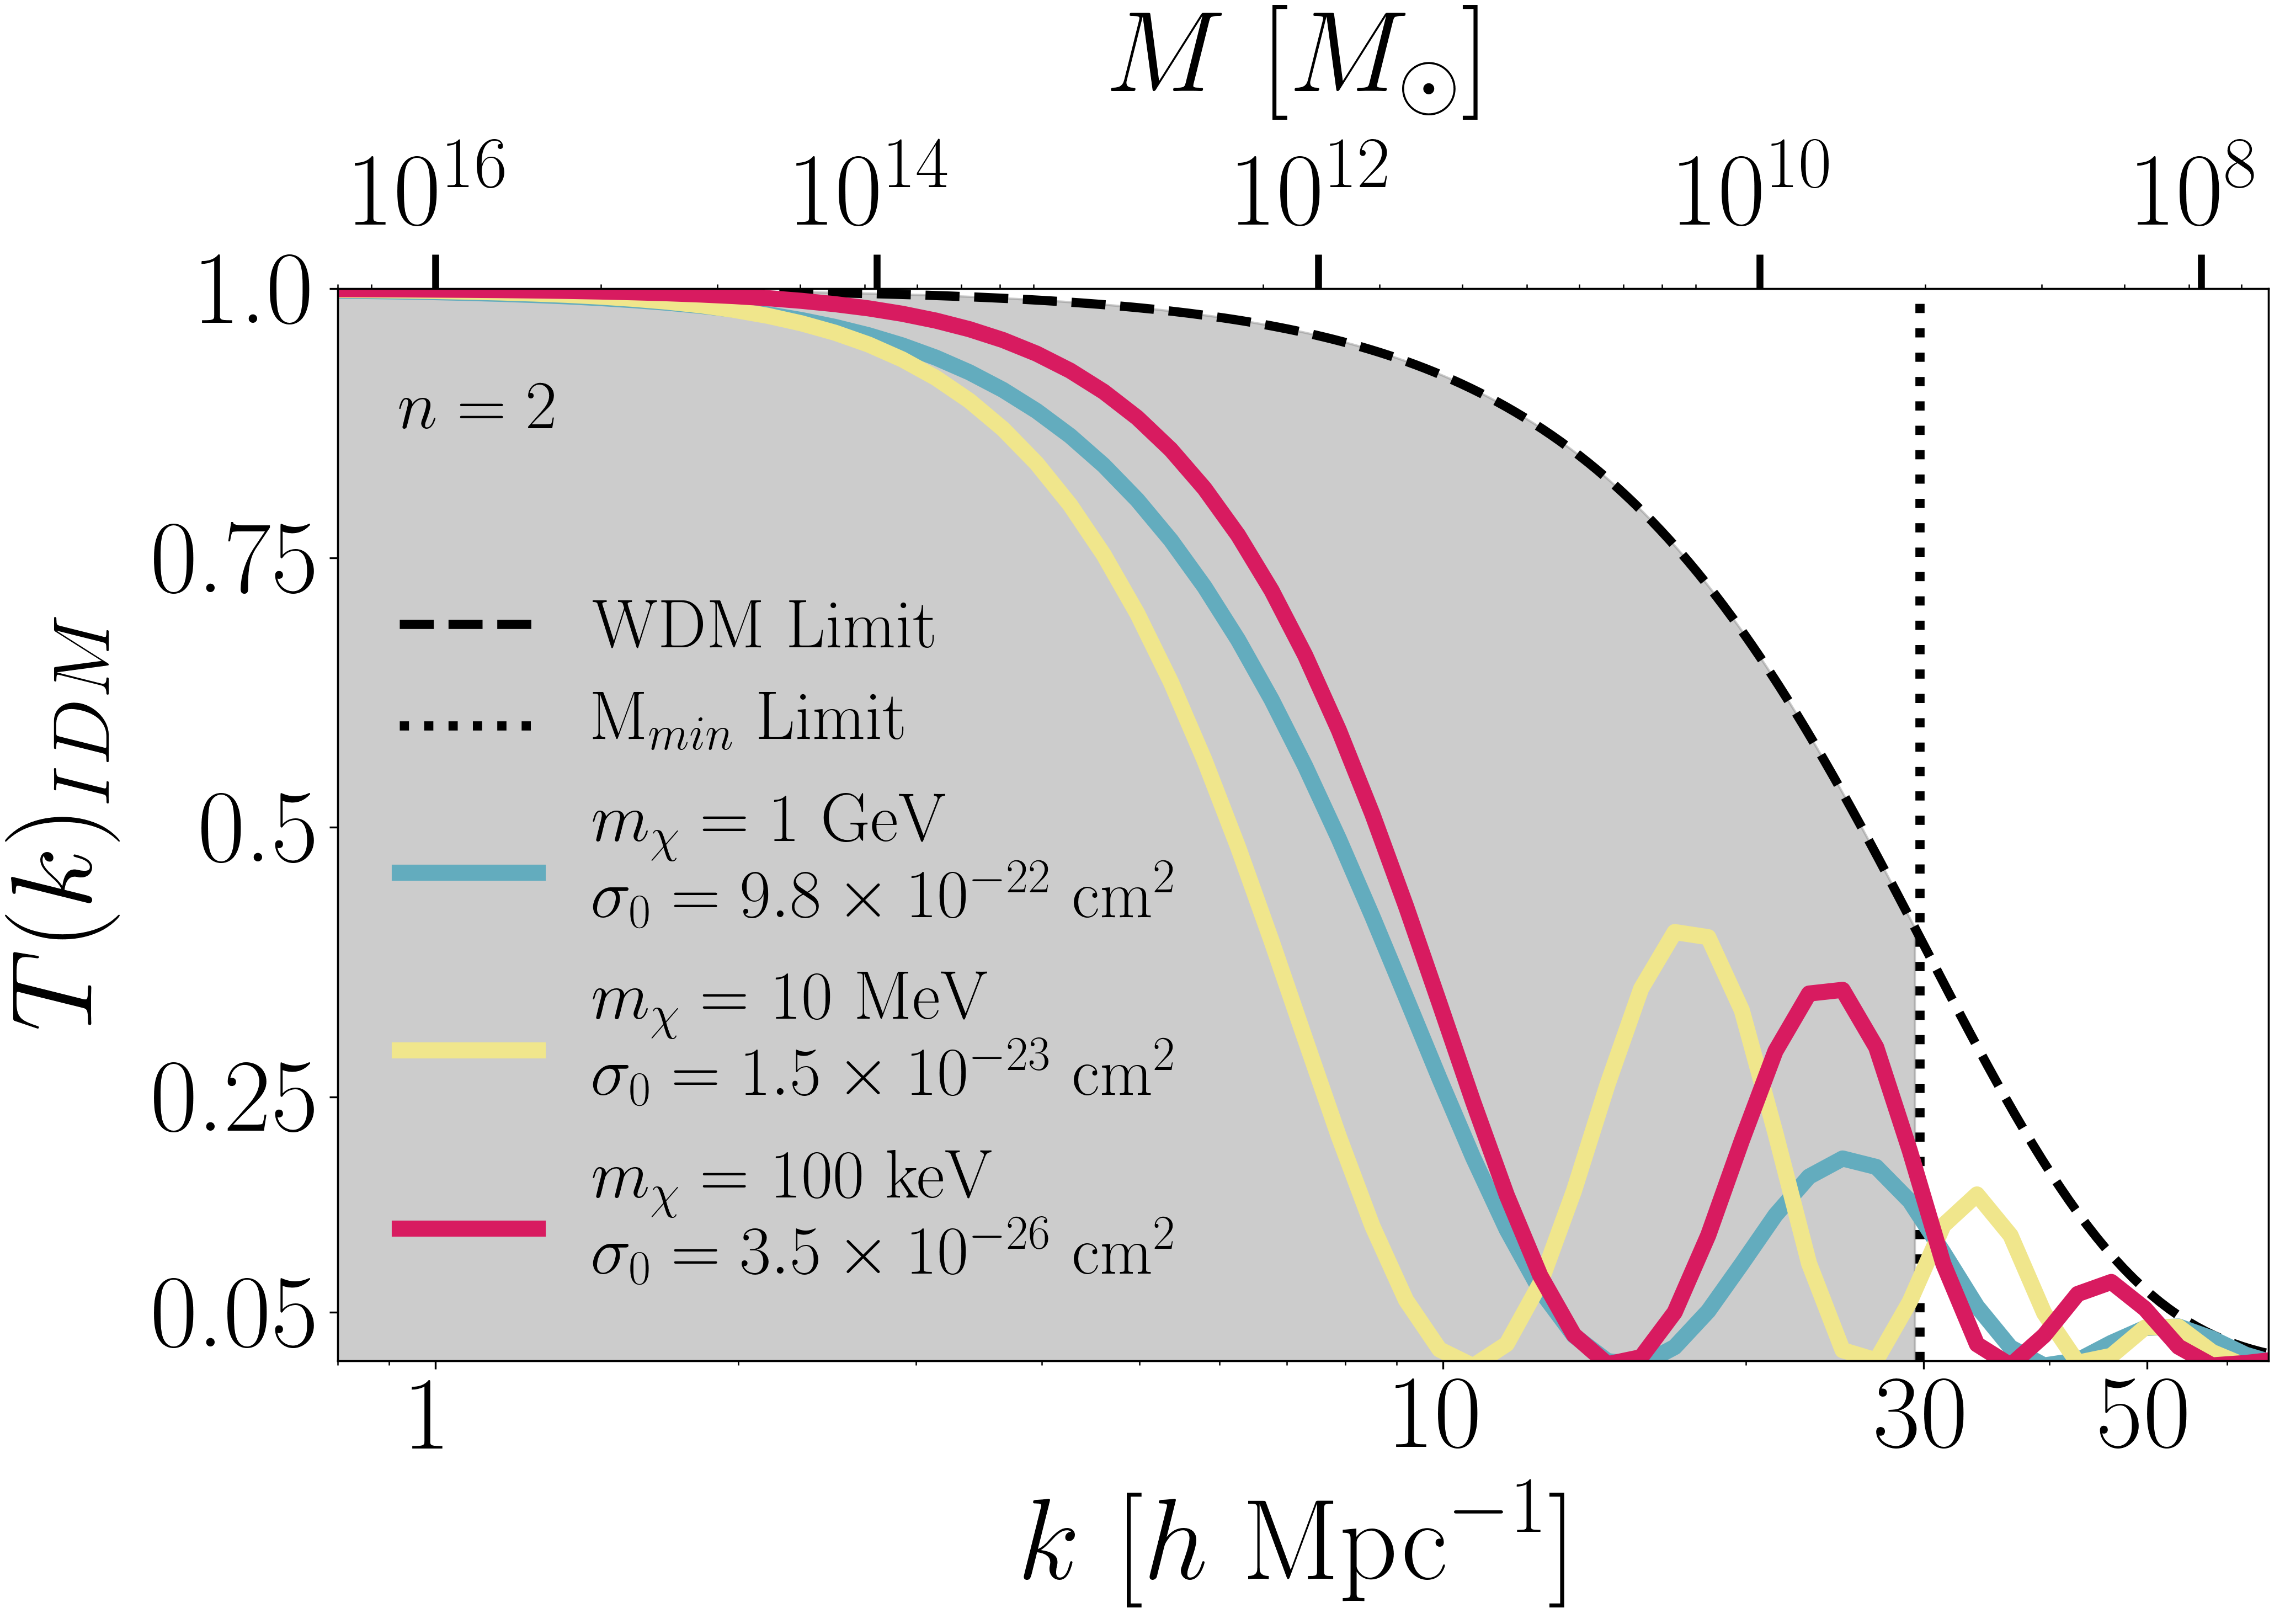

In [12]:
fig = plt.figure(figsize=(14,10))    
ax = fig.add_subplot(111)
ax2 = ax.twiny()

ks2 = np.logspace(-5,4,1000)
ax.semilogx(ks2,vds0.transfer(ks2,3.3)**2,linestyle='--',label='WDM Limit',c='k',lw=4)
ax.axvline(klim,c='k',ls=':',lw=4,label=r'M$_{min}$ Limit')
ax.fill_between(np.logspace(-5,4,1000), -10, vds0.transfer(ks2,3.3)**2,where=np.logspace(-5,4,1000)<klimit,color='grey',alpha=0.4)

tk_idm,ks,sigma0 = vds0.single_tk(npow=2,m=1,label=r'$m_{\chi}=1$ GeV' "\n" r'$\sigma_0=9.8\times 10^{-22}$ cm$^2$',c='#63acbe',sigmas=smallSigs,index=10,lw=7)
tk_idm,ks,sigma0 = vds0.single_tk(npow=2,m=0.01,label=r'$m_{\chi}=$ 10 MeV' '\n' r'$\sigma_0= 1.5\times 10^{-23}$ cm$^2$',c='khaki',sigmas=smallSigs,index=28,lw=7)
tk_idm,ks,sigma0 = vds0.single_tk(npow=2,m=0.0001,label=r'$m_{\chi}=$ 100 keV' '\n' r'$\sigma_0= 3.5\times 10^{-26}$ cm$^2$',c='#D81B60',sigmas=smallSigs,index=54,lw=7)
ax.text(0.92,0.87,"$n=2$",fontsize=30)

ax.set_xscale('log')
ax.set_xlim(0.8,66)
ax.set_ylim(0.005,1.)
ax.set_xlabel(r'$k$ [$h\ \rm{Mpc}^{-1}$]',fontsize=50,labelpad=5)
ax.set_ylabel(r'$T(k)_{IDM}$',fontsize=50,labelpad=10)
ax.set_xticks([1,10,30,50])
ax.set_xticklabels(["1","10","30","50"],fontsize=45)
ax.set_yticks([0.05,0.25,0.5,0.75,1.0])
ax.set_yticklabels([0.05,0.25,0.5,0.75,1.0],fontsize=45)
ax.legend(fontsize=30,framealpha=0,loc='lower left')

ax2.set_xscale('log')
ax2.set_xlim(0.08,66)
ax2.set_xticks([vds0.mhm2khm(10**16),vds0.mhm2khm(10**14),vds0.mhm2khm(10**12),vds0.mhm2khm(10**10),vds0.mhm2khm(10**8)])
ax2.set_xticklabels([r'10$^{16}$',r'10$^{14}$',r'10$^{12}$',r'10$^{10}$',r'10$^{8}$'],fontsize=45)
ax2.set_xlabel(r'$M$ [$M_{\rm{\odot}}$]',fontsize=50,labelpad=20)
ax2.tick_params(length=15,width=3)

plt.tight_layout()
plt.savefig("plots/exclusions/n2cons.png",transparent=True)

# Limits

Analytic approach improves upon CMB limits by:<br>
&nbsp; &nbsp; &nbsp; &nbsp;2 orders of magnitude for n=0<br>
&nbsp; &nbsp; &nbsp; &nbsp;5 orders of magnitude for n=2<br>
&nbsp; &nbsp; &nbsp; &nbsp;7 orders of magnitude for n=4

Conservative approach improves upon CMB limits by:<br>
&nbsp; &nbsp; &nbsp; &nbsp;2 orders of magnitude for n=0<br>
&nbsp; &nbsp; &nbsp; &nbsp;4 orders of magnitude for n=2<br>
&nbsp; &nbsp; &nbsp; &nbsp;5 orders of magnitude for n=4

findfont: Font family ['stix'] not found. Falling back to DejaVu Sans.


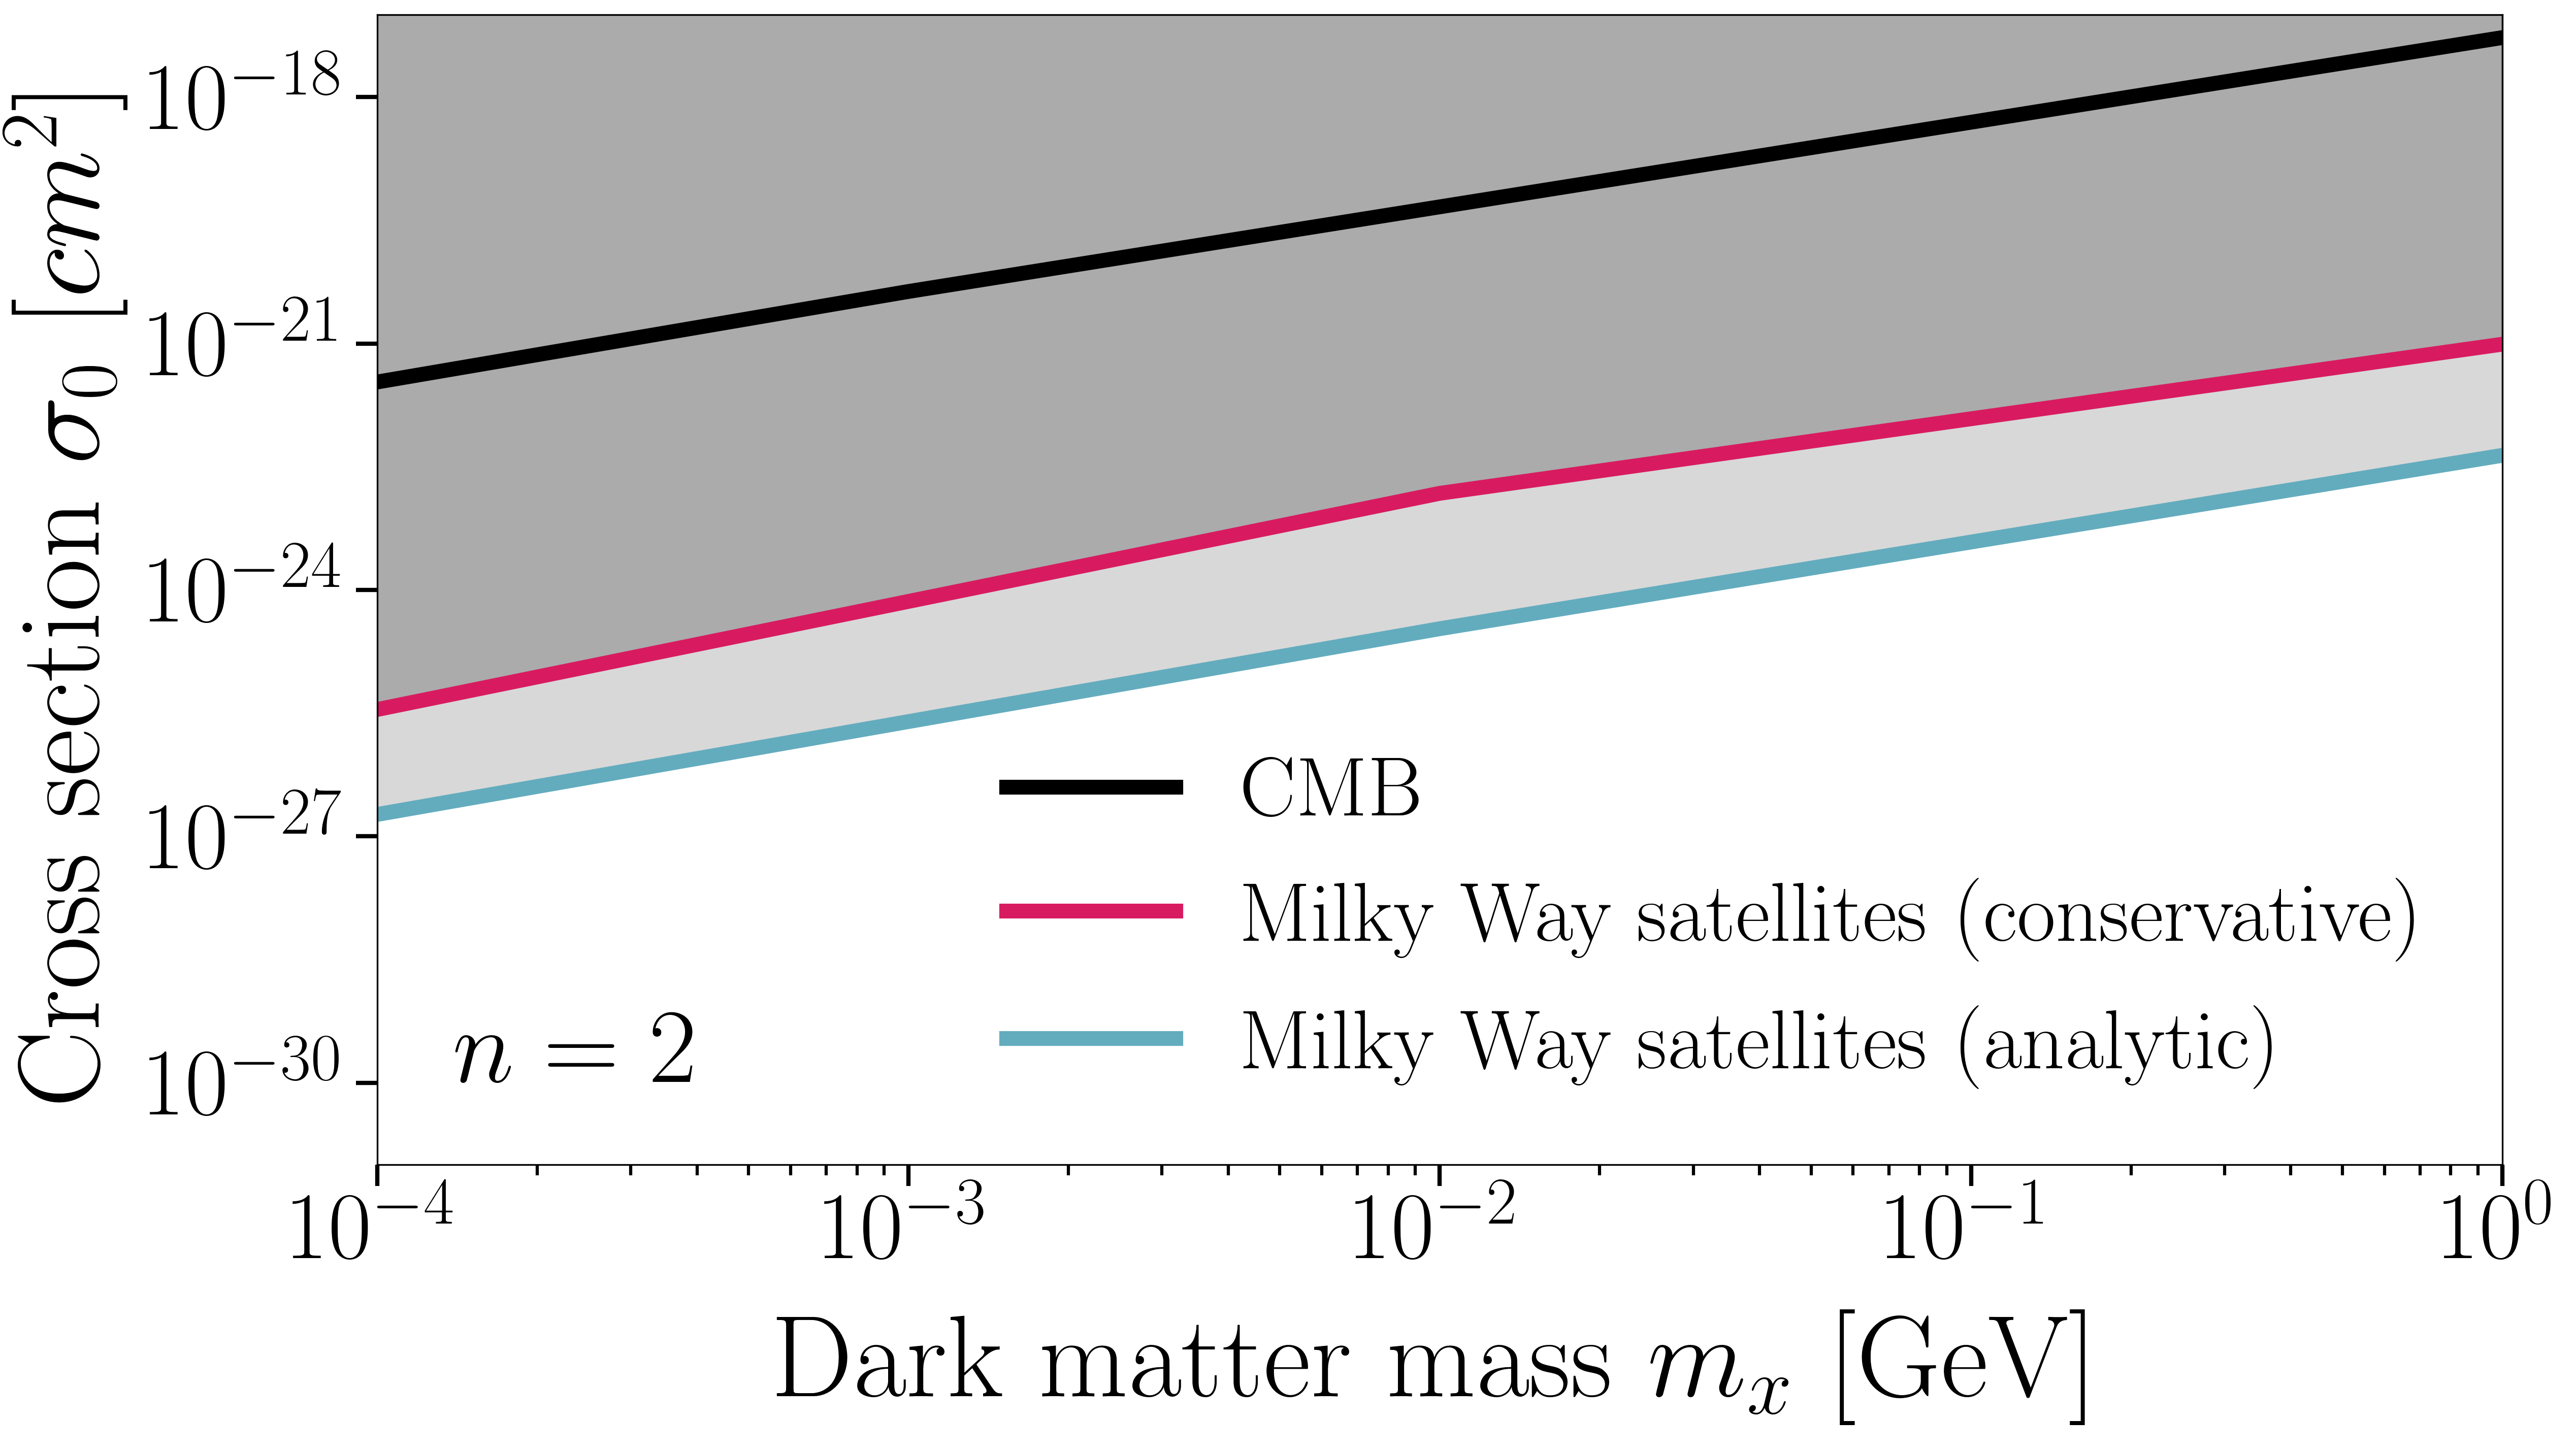

In [13]:
sigs2cons = [3.5e-26,1.5e-23,9.8e-22]
sigs2_anal = [vds0.sig(klim,2.)[0],vds0.sig(klim,2.)[2],vds0.sig(klim,2.)[4]]
sigs2_eft = [4.2e-23,4.3e-21,5.3e-18,2.2e-15]
mass = [0.0001,0.01,1]
mass_eft = [1.5e-5,0.001,1,1000]

plt.figure(figsize=(18,10))

plt.loglog(mass_eft,sigs2_eft,label="CMB",linestyle='-',c='k',lw=7)
plt.loglog(mass,sigs2cons,label="Milky Way satellites (conservative)",linestyle='-',c='#D81B60',lw=7)
plt.loglog(mass, sigs2_anal, label="Milky Way satellites (analytic)",lw=7,linestyle='-',c='#63acbe')
plt.fill_between(mass, sigs2_anal, 1, color='grey', alpha=0.3)
plt.fill_between(mass, sigs2cons, 1, color='grey', alpha=0.5)
plt.text(1.4e-4,1e-30,"$n=2$",fontsize=50)
plt.yticks([1e-30,1e-27,1e-24,1e-21,1e-18],["$10^{-30}$","$10^{-27}$","$10^{-24}$","$10^{-21}$","$10^{-18}$"])
plt.ylim(1e-31,1e-17)

plt.xlim(1e-4,1)
plt.ylabel(r"Cross section $\sigma_0$ [$cm^2$]",fontsize=55,labelpad=5)
plt.xlabel(r"Dark matter mass $m_x$ [GeV]",fontsize=55,labelpad=20)
plt.legend(fontsize=40,loc='lower right',framealpha=0)
plt.tick_params(labelsize=45,length=10,width=2)
plt.tick_params(which='minor',length=5,width=1.5)

Cross-section (sigma0) = 9.770099572992246e-22
Cross-section (sigma0) = 2.983647240283334e-23


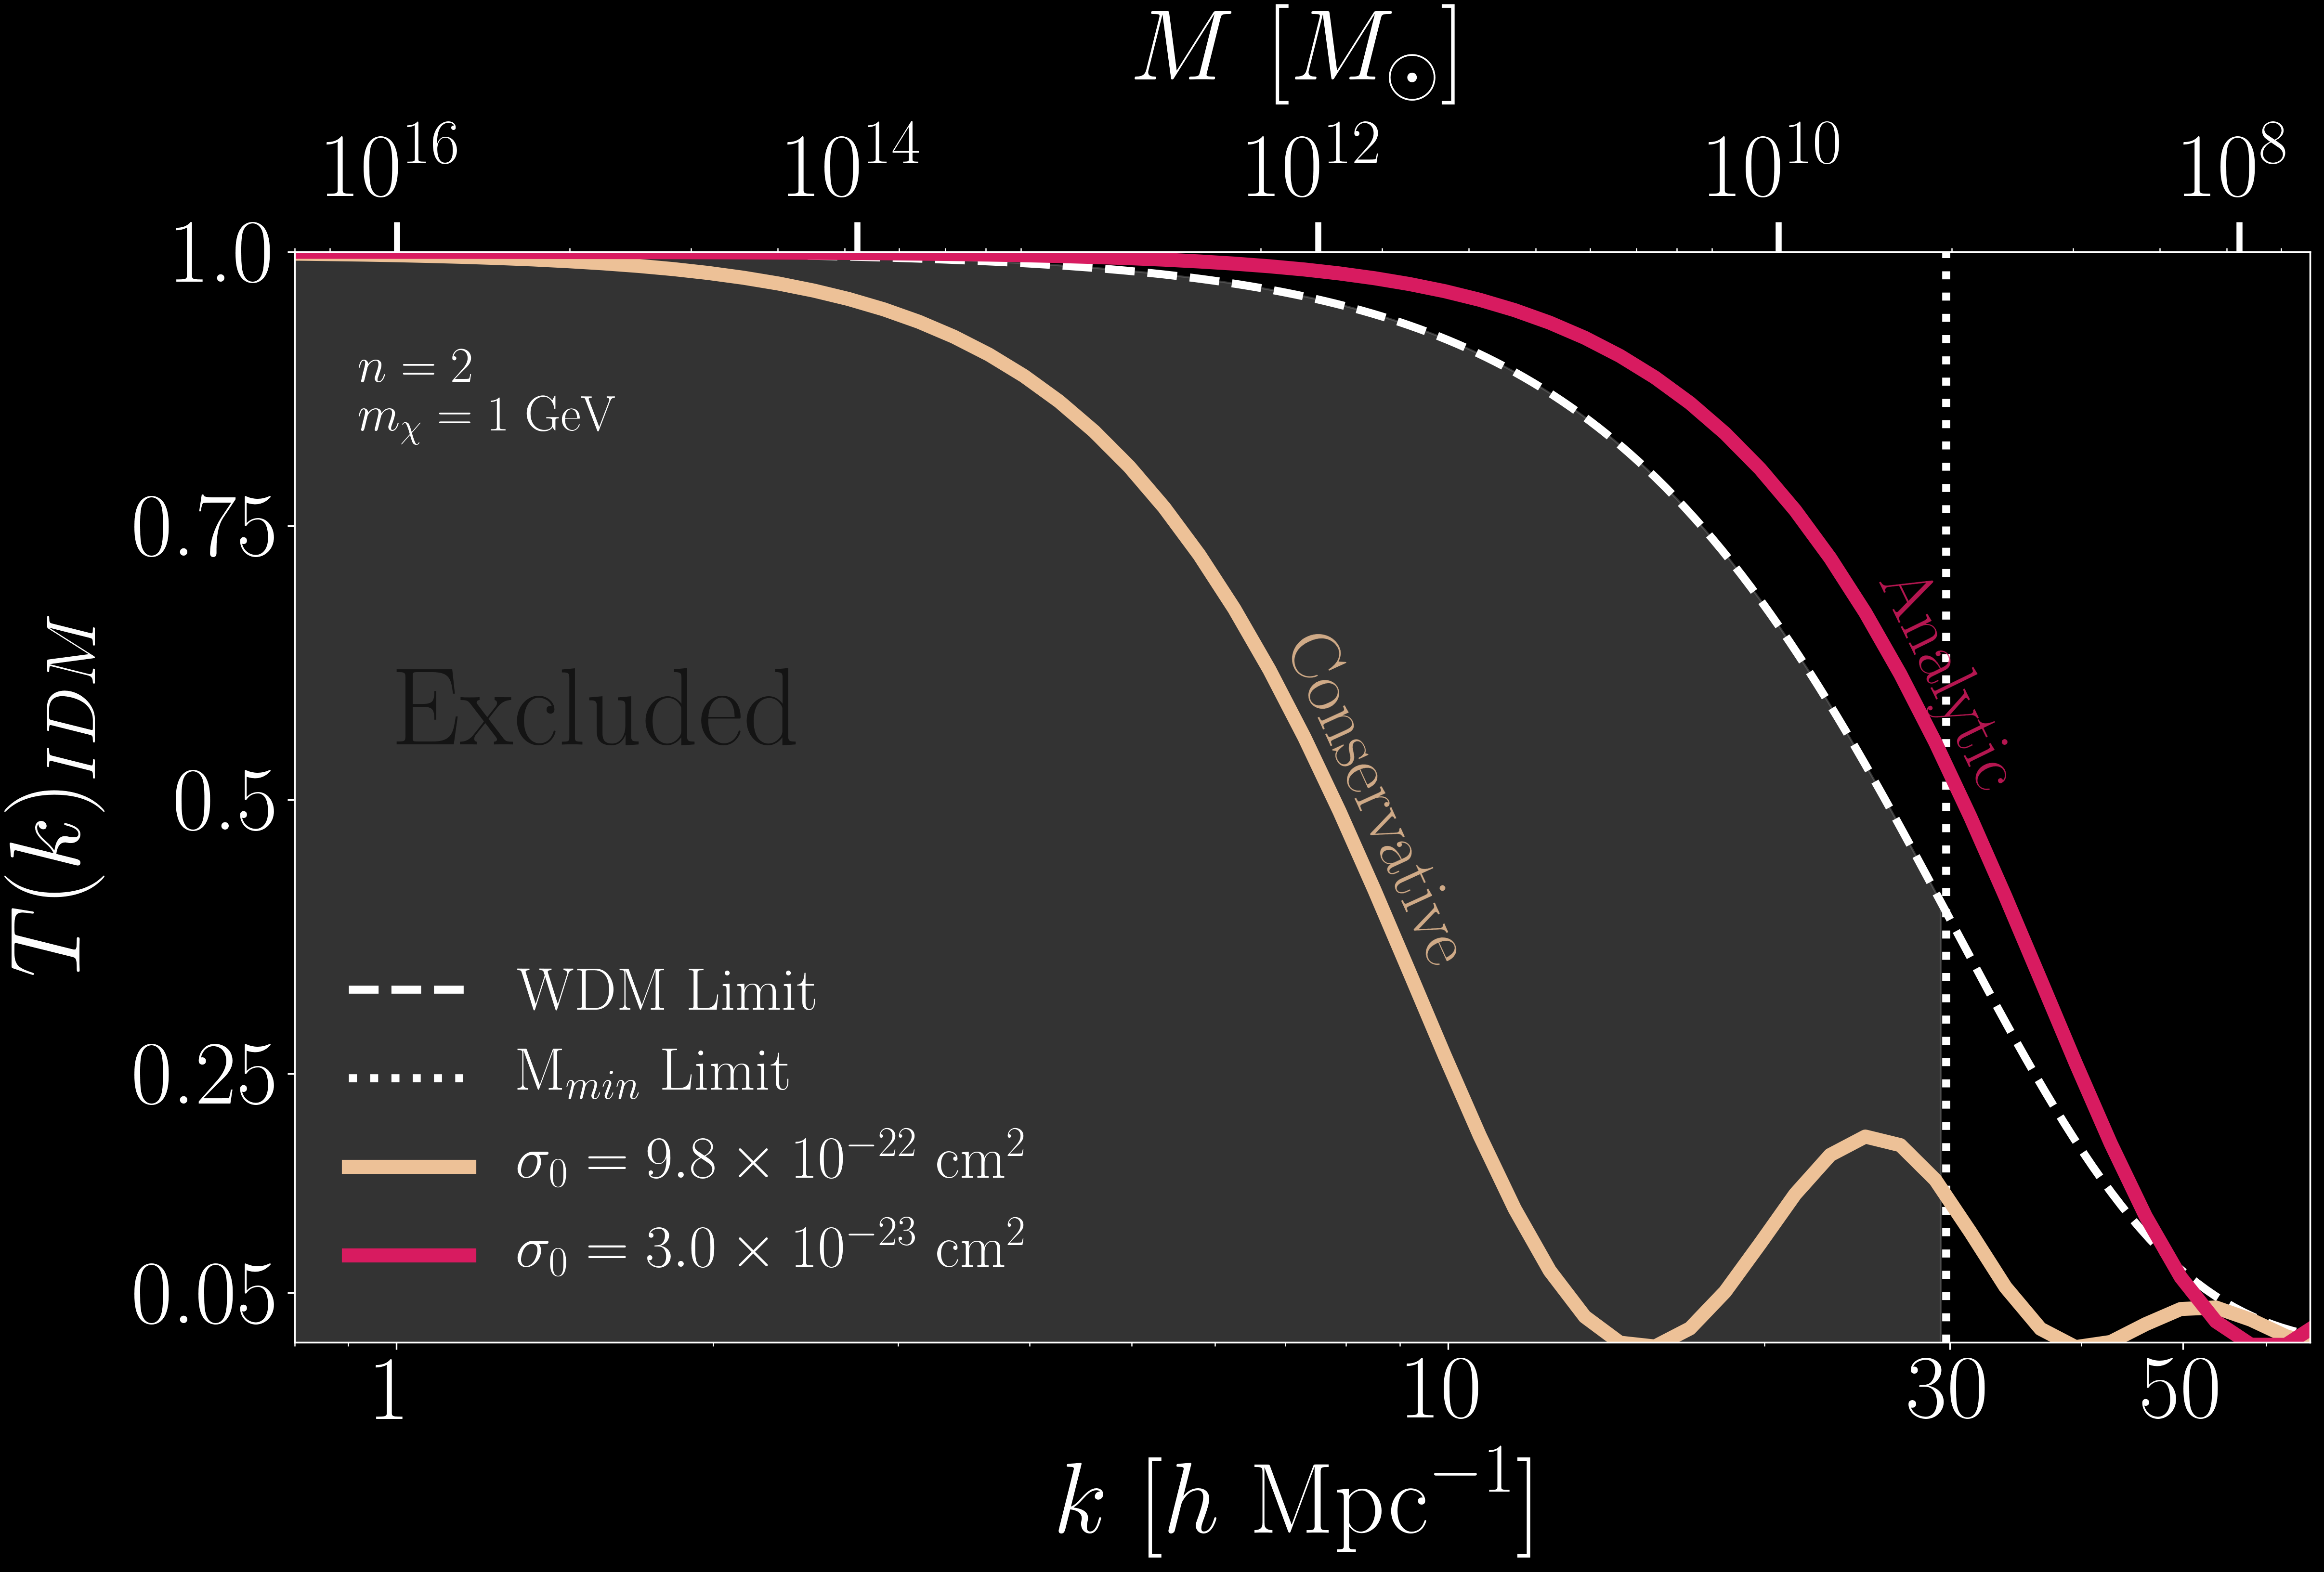

In [24]:
fig = plt.figure(figsize=(18,10))  
plt.style.use('dark_background')
ax = fig.add_subplot(111)
ax2 = ax.twiny()

ks2 = np.logspace(-5,4,1000)
ax.semilogx(ks2,vds0.transfer(ks2,3.3)**2,linestyle='--',label='WDM Limit',c='w',lw=4)
ax.axvline(klim,c='w',ls=':',lw=4,label=r'M$_{min}$ Limit')
ax.fill_between(np.logspace(-5,4,1000), -10, vds0.transfer(ks2,3.3)**2,where=np.logspace(-5,4,1000)<klimit,color='grey',alpha=0.4)
ax.text(1.,0.55,"Excluded",c='k',alpha=0.6,fontsize=55)

tk_idm_c,ks,sigma0 = vds0.single_tk(npow=2,m=1,c='#edc197',label=r'$\sigma_0=9.8\times 10^{-22}$ cm$^2$',sigmas=smallSigs,index=10,lw=7)
tk_idm_a,ks,sigma0 = vds0.single_tk(npow=2,m=1,c='#D81B60',label=r'$\sigma_0=3.0\times 10^{-23}$ cm$^2$',sigmas=smallSigs,index=25,lw=7)
ax.text(6.8,0.35,"Conservative",c='#edc197',rotation=-65.5,fontsize=35,alpha=0.85)
ax.text(25,0.51,"Analytic",c='#D81B60',rotation=-64,fontsize=35,alpha=0.85)
ax.text(0.92,0.83,"$n=2$\n$m_{\chi}=1$ GeV",fontsize=25)

ax.set_xscale('log')
ax.set_xlim(0.8,66)
ax.set_ylim(0.005,1.)
ax.set_xlabel(r'$k$ [$h\ \rm{Mpc}^{-1}$]',fontsize=50,labelpad=5)
ax.set_ylabel(r'$T(k)_{IDM}$',fontsize=50,labelpad=10)
ax.set_xticks([1,10,30,50])
ax.set_xticklabels(["1","10","30","50"],fontsize=45)
ax.set_yticks([0.05,0.25,0.5,0.75,1.0])
ax.set_yticklabels([0.05,0.25,0.5,0.75,1.0],fontsize=45)
ax.legend(fontsize=30,framealpha=0,loc='lower left')

ax2.set_xscale('log')
ax2.set_xlim(0.08,66)
ax2.set_xticks([vds0.mhm2khm(10**16),vds0.mhm2khm(10**14),vds0.mhm2khm(10**12),vds0.mhm2khm(10**10),vds0.mhm2khm(10**8)])
ax2.set_xticklabels([r'10$^{16}$',r'10$^{14}$',r'10$^{12}$',r'10$^{10}$',r'10$^{8}$'],fontsize=45)
ax2.set_xlabel(r'$M$ [$M_{\rm{\odot}}$]',fontsize=50,labelpad=20)
ax2.tick_params(length=15,width=3)

# Summary

**Objective:** Constrain alternative models of DM which assume DM-proton interactions

**<font color=teal>Analytic approach: </font>**  Kinetic decoupling $\rightarrow$ Point of last scattering $\rightarrow$ Critical scale of suppression $\rightarrow$ Critical (minimum halo) mass $\rightarrow$ Scatering cross-section<br>

**<font color=crimson>Conservative approach: </font>**  Critical mass $\rightarrow$ Critical scale $\rightarrow$ WDM transfer function $\rightarrow$ IDM transfer function $\rightarrow$ Scattering cross-section

**Results:** Several orders of magnitude improvement upon prior limits

# Takeaway
New observations of the minimum halo mass of Milky Way satellite galaxies allow for the imposition of stringent constraints on the scattering cross-section of velocity dependent DM-proton interactions